### Data Preprocessing


In [36]:
# required pacakges
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import os

625.0
[0 1 2 4]
[0 1 2 3]


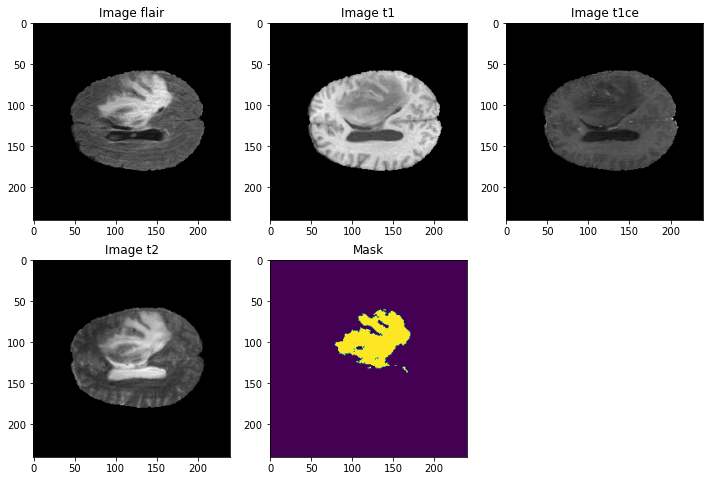

In [37]:
##########################
#This part of the code to get an initial understanding of the dataset.
#################################
#PART 1: Load sample images and visualize
#Includes, dividing each image by its max to scale them to [0,1]
#Converting mask from float to uint8
#Changing mask pixel values (labels) from 4 to 3 (as the original labels are 0, 1, 2, 4)
#Visualize
###########################################
#View a few images

#Note: Segmented file name in Folder 355 has a weird name. Rename it to match others.

TRAIN_DATASET_PATH = r"D:\Amjid data\segmentation\BraTS2020_TrainingData/"
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(r"D:\Amjid data\segmentation\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii").get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(r"D:\Amjid data\segmentation\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii").get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(r"D:\Amjid data\segmentation\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii").get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(r"D:\Amjid data\segmentation\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t2.nii").get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(r"D:\Amjid data\segmentation\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_seg.nii").get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

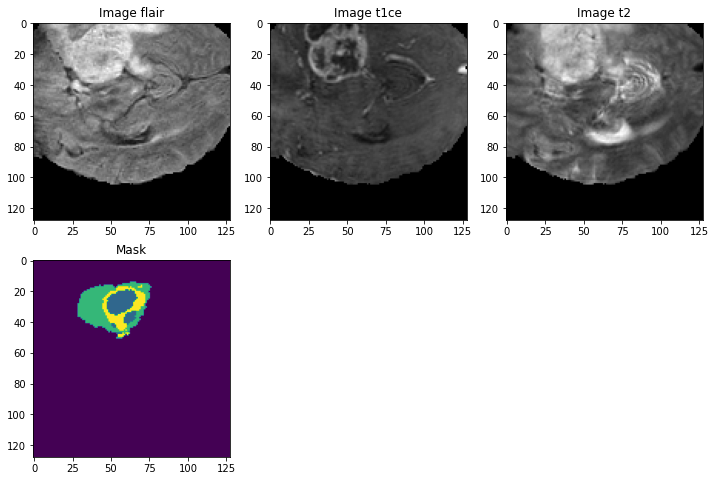

In [38]:
##################################################
#PART 2: Explore the process of combining images to channels and divide them to patches
#Includes...
#Combining all 4 images to 4 channels of a numpy array.
#
################################################
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(233)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(234)
# plt.imshow(combined_x[:,:,n_slice, 3], cmap='gray')
# plt.title('Image t1')
# plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


# imsave(r"D:\Abdul Hai\Projects\Segmentation\new_dataset_code\combined255.tif", combined_x)
# np.save(r"D:\Abdul Hai\Projects\Segmentation\new_dataset_code\combined255.npy", combined_x)
#Verify image is being read properly
#my_img=imread('BraTS2020_TrainingData/combined255.tif')

# my_img=np.load(r"D:\Abdul Hai\Projects\Segmentation\new_dataset_code\combined255.npy")

test_mask = to_categorical(test_mask, num_classes=4)

# Data Augmentation

In [39]:
import albumentations as A

transform = A.Compose([
#     A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit = 50),
])

def augment(com_img, com_mask, num):
    global transform
    transform_img = transform(image = com_img)['image']
    transform_mask = transform(image = com_mask)['image']
    np.save(os.path.join(os.getcwd(),'Augmented_dataset','images','image_')+str(num)+'.npy', transform_img)
    np.save(os.path.join(os.getcwd(),'Augmented_dataset','masks','mask_')+str(num)+'.npy', transform_mask)

In [43]:
####################################################################
#####################################
#End of understanding the dataset. Now get it organized.
#####################################

#Now let us apply the same as above to all the images...
#Merge channels, crop, patchify, save
#GET DATA READY =  GENERATORS OR OTHERWISE

#Keras datagenerator does ntot support 3d
import time
start = time.time()
# # # images lists harley
# t1_list = sorted(glob.glob(os.path.join(os.getcwd(),'archive (1)','BraTS2020_TrainingData','MICCAI_BraTS2020_TrainingData','**/*t2.nii')))
t2_list = sorted(glob.glob(os.path.join(os.getcwd(),'BraTS2020_TrainingData','MICCAI_BraTS2020_TrainingData','**/*t2.nii')))
t1ce_list = sorted(glob.glob(os.path.join(os.getcwd(),'BraTS2020_TrainingData','MICCAI_BraTS2020_TrainingData','**/*t1ce.nii')))
flair_list = sorted(glob.glob(os.path.join(os.getcwd(),'BraTS2020_TrainingData','MICCAI_BraTS2020_TrainingData','**/*flair.nii')))
mask_list = sorted(glob.glob(os.path.join(os.getcwd(),'BraTS2020_TrainingData','MICCAI_BraTS2020_TrainingData','**/*seg.nii')))

#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes

for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
#     temp_image_t1=nib.load(t1_list[img]).get_fdata()
#     temp_image_t1=scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]

    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save(os.path.join(os.getcwd(),'preprocessed_dataset','images','image_')+str(img)+'.npy', temp_combined_images)
        np.save(os.path.join(os.getcwd(),'preprocessed_dataset','masks','mask_')+str(img)+'.npy', temp_mask)
        # augmentation
#         augment(temp_combined_images,temp_mask,img)
    else:
        print("I am useless")   
end = time.time() - start   
################################################################

Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
I am useless
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
Save Me
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks number:  19
Save Me
Now p

Save Me
Now preparing image and masks number:  162
Save Me
Now preparing image and masks number:  163
Save Me
Now preparing image and masks number:  164
Save Me
Now preparing image and masks number:  165
Save Me
Now preparing image and masks number:  166
Save Me
Now preparing image and masks number:  167
Save Me
Now preparing image and masks number:  168
Save Me
Now preparing image and masks number:  169
Save Me
Now preparing image and masks number:  170
Save Me
Now preparing image and masks number:  171
Save Me
Now preparing image and masks number:  172
Save Me
Now preparing image and masks number:  173
Save Me
Now preparing image and masks number:  174
Save Me
Now preparing image and masks number:  175
Save Me
Now preparing image and masks number:  176
I am useless
Now preparing image and masks number:  177
Save Me
Now preparing image and masks number:  178
Save Me
Now preparing image and masks number:  179
Save Me
Now preparing image and masks number:  180
Save Me
Now preparing imag

Save Me
Now preparing image and masks number:  322
Save Me
Now preparing image and masks number:  323
Save Me
Now preparing image and masks number:  324
I am useless
Now preparing image and masks number:  325
Save Me
Now preparing image and masks number:  326
Save Me
Now preparing image and masks number:  327
Save Me
Now preparing image and masks number:  328
Save Me
Now preparing image and masks number:  329
Save Me
Now preparing image and masks number:  330
Save Me
Now preparing image and masks number:  331
Save Me
Now preparing image and masks number:  332
Save Me
Now preparing image and masks number:  333
Save Me
Now preparing image and masks number:  334
Save Me
Now preparing image and masks number:  335
Save Me
Now preparing image and masks number:  336
Save Me
Now preparing image and masks number:  337
Save Me
Now preparing image and masks number:  338
Save Me
Now preparing image and masks number:  339
Save Me
Now preparing image and masks number:  340
I am useless
Now preparing

In [44]:
print("Preprocessing End time in seconds: ",end)

Preprocessing End time 757.782742023468


## Dataset Splitting

In [45]:
import splitfolders  # or import split_folders

input_folder = r"D:\Amjid data\segmentation\preprocessed_dataset/"
output_folder = r"D:\Amjid data\segmentation\train_val_dataset/"
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.50, .50), group_prefix=None) # default values

Copying files: 688 files [02:03,  5.56 files/s]


### Data Generator
* keras datagen is not able to handel .nii files and .npy files, to prepared the dataset for training we need to make a custom data generator...

In [46]:
"""
Custom data generator to work with BraTS2020 dataset.
Can be used as a template to create your own custom data generators. 

No image processing operations are performed here, just load data from local directory
in batches. 

"""

#from tifffile import imsave, imread
import os
import numpy as np

In [47]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

############################################

In [6]:
# train_mask_dir
# train_mask_list

In [48]:
#Test the generator

from matplotlib import pyplot as plt
import random

train_img_dir = r"D:\Amjid data\segmentation\train_val_dataset\train\images/"
train_mask_dir = r"D:\Amjid data\segmentation\train_val_dataset\train\masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

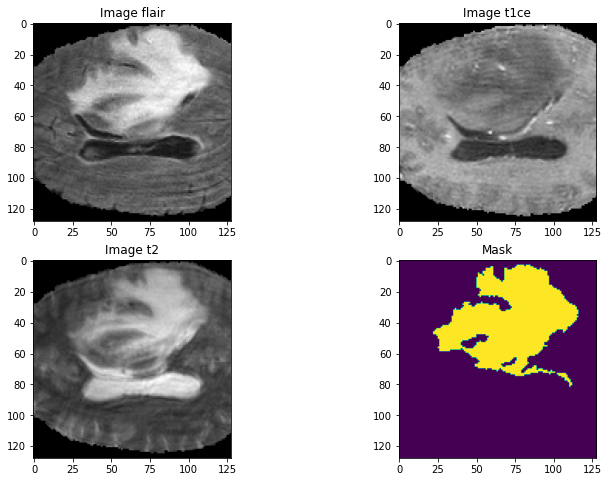

In [49]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

### N4ITK Algorithm for data augmentation

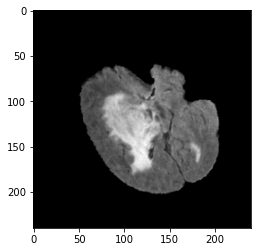

In [16]:
import SimpleITK as sitk
import numpy as np

# Read image
image_file = r"D:\Amjid data\segmentation\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii"
image = sitk.ReadImage(image_file)

# Generate random flip axis
axis = np.random.randint(3)

# Flip image
flipped_image = sitk.Flip(image)

# Get image size
size = image.GetSize()

# Generate random crop start index
start_index = [np.random.randint(0, size[0]-64), np.random.randint(0, size[1]-64),np.random.randint(0, size[2]-64)]

# Crop image
cropped_image = sitk.Crop(image, start_index, [64, 64, 64])

# Define rotation transformation
angle = [np.pi/6,np.pi/6,np.pi/6] # 30 degrees for each axis
rotation = sitk.Euler3DTransform()
rotation.SetCenter(image.TransformContinuousIndexToPhysicalPoint(np.array(image.GetSize())/2.0))
rotation.SetRotation(*angle)

# Apply rotation transformation to image
rotated_image = sitk.Resample(image, rotation)
new_img = sitk.GetArrayFromImage(rotated_image)
plt.imshow(new_img[70,:,:],'gray')


### Histogram of dataset image

In [148]:
# import SimpleITK as sitk

# # Read image
# # image_file = "path/to/image.nii"
# # image = sitk.ReadImage(image_file)

# # # Generate histogram
# # histogram = sitk.Statistics.Histogram(image, numberOfBins=256)

# import SimpleITK as sitk
# import numpy as np

# # Read image
# # image_file = "path/to/image.nii"
# image = sitk.ReadImage(image_file)

# # # Convert image to numpy array
# # image_data = sitk.GetArrayFromImage(image)

# # # Generate histogram
# # histogram, bin_edges = np.histogram(image_data, bins=256)


# # import matplotlib.pyplot as plt
# # plt.hist(histogram)
# # plt.show()
# # histogram = sitk.Histogram(image, numberOfBins=256, lowerBound=0, upperBound=255)
# # plt.hist(histogram)
# # plt.show()


# # Convert image to numpy array
# image_data = sitk.GetArrayFromImage(image)

# # Generate histogram
# histogram, bin_edges = np.histogram(image_data, bins=4)

# plt.hist(histogram)
# plt.show()

### Unet Model Creation

In [50]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU
import os

In [85]:
"""
@author: Sreenivas Bhattiprolu

Converted my standard 2D Unet to 3D. 

"""

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

#Test if everything is working ok. 
model = simple_unet_model(128, 128, 128, 3, 4)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_95 (Conv3D)             (None, 128, 128, 12  1312        ['input_6[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_45 (Dropout)           (None, 128, 128, 12  0           ['conv3d_95[0][0]']              
                                8, 16)                                                      

                                                                                                  
 conv3d_107 (Conv3D)            (None, 32, 32, 32,   221248      ['concatenate_21[0][0]']         
                                64)                                                               
                                                                                                  
 dropout_51 (Dropout)           (None, 32, 32, 32,   0           ['conv3d_107[0][0]']             
                                64)                                                               
                                                                                                  
 conv3d_108 (Conv3D)            (None, 32, 32, 32,   110656      ['dropout_51[0][0]']             
                                64)                                                               
                                                                                                  
 conv3d_tr

In [52]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


### Unet Model training and prediction

In [53]:
#Define the image generators for training and validation
import os
train_img_dir = r"D:\Amjid data\segmentation\train_val_dataset\train\images/"
train_mask_dir = r"D:\Amjid data\segmentation\train_val_dataset\train\masks/"

val_img_dir = r"D:\Amjid data\segmentation\train_val_dataset\val\images/"
val_mask_dir = r"D:\Amjid data\segmentation\train_val_dataset\val\masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

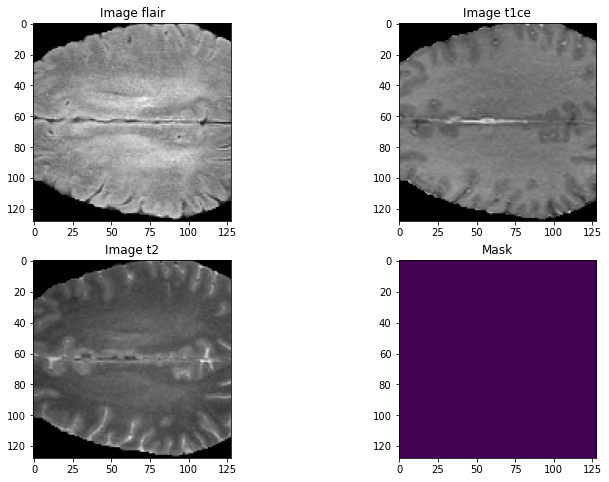

In [54]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [55]:
# Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = Adam(LR)

In [87]:
#Fit the model 

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_114 (Conv3D)            (None, 128, 128, 12  1312        ['input_7[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_54 (Dropout)           (None, 128, 128, 12  0           ['conv3d_114[0][0]']             
                                8, 16)                                                      

                                                                                                  
 conv3d_126 (Conv3D)            (None, 32, 32, 32,   221248      ['concatenate_25[0][0]']         
                                64)                                                               
                                                                                                  
 dropout_60 (Dropout)           (None, 32, 32, 32,   0           ['conv3d_126[0][0]']             
                                64)                                                               
                                                                                                  
 conv3d_127 (Conv3D)            (None, 32, 32, 32,   110656      ['dropout_60[0][0]']             
                                64)                                                               
                                                                                                  
 conv3d_tr

In [57]:
print(model.summary())

print(model.input_shape)
print(model.output_shape)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_76 (Conv3D)             (None, 128, 128, 12  1312        ['input_5[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_36 (Dropout)           (None, 128, 128, 12  0           ['conv3d_76[0][0]']              
                                8, 16)                                                      

                                                                                                  
 conv3d_88 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_17[0][0]']         
                                64)                                                               
                                                                                                  
 dropout_42 (Dropout)           (None, 32, 32, 32,   0           ['conv3d_88[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_89 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_42[0][0]']             
                                64)                                                               
                                                                                                  
 conv3d_tr

In [84]:
# import matplotlib.pyplot as plt
# from keras.callbacks import LearningRateScheduler
# import math

# # Define the learning rate schedule function
# def step_decay(epoch):
#     initial_lrate = 0.0001
#     drop = 0.5
#     epochs_drop = 1.0
#     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#     return lrate

# # Create a list to store the learning rate at each epoch
# lrates = []

# # train the model
# model.fit(train_img_datagen, steps_per_epoch=steps_per_epoch,epochs=100,
#           callbacks=[LearningRateScheduler(step_decay)], validation_data=val_img_datagen,
#           validation_steps=val_steps_per_epoch)

# #get the learning rate after each epoch
# for i in range(100):
#     lrates.append(step_decay(i))

# # plot the learning rate schedule
# plt.plot(range(100), lrates)
# plt.xlabel('Epoch')
# plt.ylabel('Learning Rate')
# plt.title('Learning Rate Schedule')
# plt.show()

In [89]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
callbacks_list = [reduce_lr]
history = model.fit(train_img_datagen, steps_per_epoch=steps_per_epoch,epochs=100,
          callbacks=callbacks_list, validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch)

Epoch 1/100
131/131 [==============================] - 209s 2s/step - loss: 0.9284 - accuracy: 0.9333 - iou_score: 0.2358 - val_loss: 0.9367 - val_accuracy: 0.9075 - val_iou_score: 0.2170 - lr: 5.0000e-05
Epoch 2/100
131/131 [==============================] - 209s 2s/step - loss: 0.9163 - accuracy: 0.9495 - iou_score: 0.2879 - val_loss: 0.9209 - val_accuracy: 0.9202 - val_iou_score: 0.3031 - lr: 5.0000e-05
Epoch 3/100
131/131 [==============================] - 223s 2s/step - loss: 0.9109 - accuracy: 0.9515 - iou_score: 0.3189 - val_loss: 0.9208 - val_accuracy: 0.9117 - val_iou_score: 0.2966 - lr: 5.0000e-05
Epoch 4/100
131/131 [==============================] - 209s 2s/step - loss: 0.9029 - accuracy: 0.9514 - iou_score: 0.3518 - val_loss: 0.9067 - val_accuracy: 0.9195 - val_iou_score: 0.3501 - lr: 5.0000e-05
Epoch 5/100
131/131 [==============================] - 209s 2s/step - loss: 0.8944 - accuracy: 0.9515 - iou_score: 0.3895 - val_loss: 0.8965 - val_accuracy: 0.9353 - val_iou_score:

Epoch 41/100
131/131 [==============================] - 209s 2s/step - loss: 0.8105 - accuracy: 0.9819 - iou_score: 0.6815 - val_loss: 0.8360 - val_accuracy: 0.9739 - val_iou_score: 0.5977 - lr: 5.0000e-05
Epoch 42/100
131/131 [==============================] - 209s 2s/step - loss: 0.8096 - accuracy: 0.9824 - iou_score: 0.6846 - val_loss: 0.8329 - val_accuracy: 0.9749 - val_iou_score: 0.6082 - lr: 5.0000e-05
Epoch 43/100
131/131 [==============================] - 209s 2s/step - loss: 0.8096 - accuracy: 0.9825 - iou_score: 0.6847 - val_loss: 0.8334 - val_accuracy: 0.9740 - val_iou_score: 0.6071 - lr: 5.0000e-05
Epoch 44/100
131/131 [==============================] - 209s 2s/step - loss: 0.8087 - accuracy: 0.9827 - iou_score: 0.6884 - val_loss: 0.8349 - val_accuracy: 0.9742 - val_iou_score: 0.6024 - lr: 5.0000e-05
Epoch 45/100
131/131 [==============================] - 209s 2s/step - loss: 0.8069 - accuracy: 0.9834 - iou_score: 0.6958 - val_loss: 0.8309 - val_accuracy: 0.9758 - val_iou_s

Epoch 81/100
131/131 [==============================] - 209s 2s/step - loss: 0.7903 - accuracy: 0.9884 - iou_score: 0.7694 - val_loss: 0.8243 - val_accuracy: 0.9792 - val_iou_score: 0.6412 - lr: 5.0000e-05
Epoch 82/100
131/131 [==============================] - 209s 2s/step - loss: 0.7899 - accuracy: 0.9887 - iou_score: 0.7707 - val_loss: 0.8264 - val_accuracy: 0.9787 - val_iou_score: 0.6329 - lr: 5.0000e-05
Epoch 83/100
131/131 [==============================] - 209s 2s/step - loss: 0.7904 - accuracy: 0.9885 - iou_score: 0.7683 - val_loss: 0.8260 - val_accuracy: 0.9782 - val_iou_score: 0.6364 - lr: 5.0000e-05
Epoch 84/100
131/131 [==============================] - 209s 2s/step - loss: 0.7907 - accuracy: 0.9884 - iou_score: 0.7667 - val_loss: 0.8269 - val_accuracy: 0.9780 - val_iou_score: 0.6264 - lr: 5.0000e-05
Epoch 85/100
131/131 [==============================] - 209s 2s/step - loss: 0.7906 - accuracy: 0.9886 - iou_score: 0.7673 - val_loss: 0.8255 - val_accuracy: 0.9784 - val_iou_s

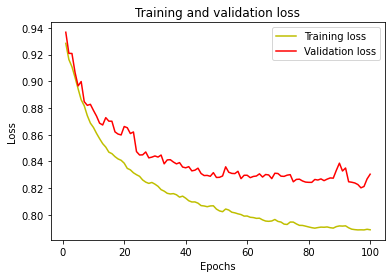

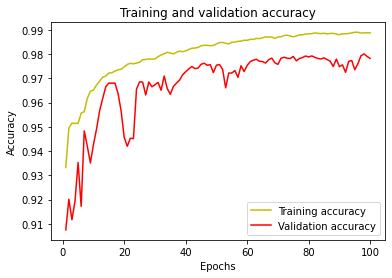

In [92]:
# model report
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Loss_100_epochs.jpg")
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("Accuracy_100_epochs.jpg")
plt.show()

In [97]:
# model saveing
model.save('brats_3d_100.hdf5')

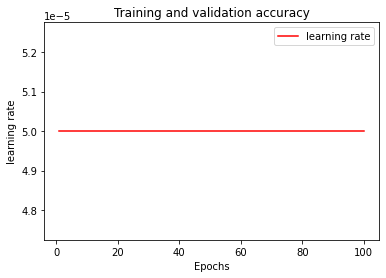

In [93]:
# learning rate
# acc = history.history['lr']
val_acc = history.history['lr']

# plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='learning rate')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('learning rate')
plt.legend()
plt.savefig("learning rate_100_epochs.jpg")
plt.show()

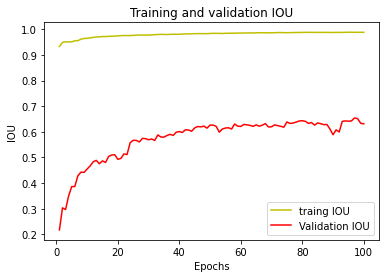

In [96]:
val = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='traing IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.savefig("IOU_score_100_epochs.jpg")
plt.show()

In [94]:
import pandas as pd
pd.DataFrame(history.history).to_csv("report_100_epochs.csv")

In [95]:
pd.read_csv('report_100_epochs.csv')

,Unnamed: 0,loss,accuracy,iou_score,val_loss,val_accuracy,val_iou_score,lr
0,0,0.928407,0.933275,0.235810,0.936731,0.907533,0.217043,0.00005
1,1,0.916308,0.949540,0.287932,0.920915,0.920168,0.303130,0.00005
2,2,0.910865,0.951536,0.318941,0.920825,0.911725,0.296613,0.00005
3,3,0.902906,0.951384,0.351773,0.906749,0.919506,0.350067,0.00005
4,4,0.894433,0.951464,0.389470,0.896523,0.935295,0.386252,0.00005
...,...,...,...,...,...,...,...,...
95,95,0.788643,0.988968,0.777093,0.822643,0.975938,0.642885,0.00005
96,96,0.788709,0.988662,0.776245,0.820168,0.979296,0.654414,0.00005
97,97,0.788639,0.988713,0.777109,0.821181,0.980063,0.651441,0.00005
98,98,0.789127,0.988767,0.774968,0.826832,0.979036,0.633515,0.00005


In [58]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('brats_3d_75.hdf5')

Epoch 1/10
131/131 [==============================] - 241s 2s/step - loss: 0.9488 - accuracy: 0.9338 - iou_score: 0.2117 - val_loss: 0.9332 - val_accuracy: 0.9039 - val_iou_score: 0.2368
Epoch 2/10
131/131 [==============================] - 236s 2s/step - loss: 0.9272 - accuracy: 0.9377 - iou_score: 0.2783 - val_loss: 0.9352 - val_accuracy: 0.8783 - val_iou_score: 0.2858
Epoch 3/10
131/131 [==============================] - 234s 2s/step - loss: 0.9165 - accuracy: 0.9459 - iou_score: 0.3148 - val_loss: 0.9253 - val_accuracy: 0.9004 - val_iou_score: 0.2987
Epoch 4/10
131/131 [==============================] - 259s 2s/step - loss: 0.9051 - accuracy: 0.9480 - iou_score: 0.3479 - val_loss: 0.9200 - val_accuracy: 0.9070 - val_iou_score: 0.3120
Epoch 5/10
131/131 [==============================] - 265s 2s/step - loss: 0.8925 - accuracy: 0.9562 - iou_score: 0.3998 - val_loss: 0.9131 - val_accuracy: 0.8835 - val_iou_score: 0.3480
Epoch 6/10
131/131 [==============================] - 270s 2s/ste

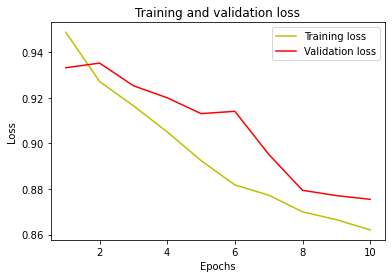

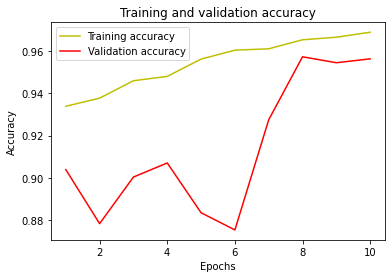

In [59]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Loss_75.jpg")
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("Accuracy_75.jpg")
plt.show()

In [60]:
import pandas as pd
pd.DataFrame(history.history).to_csv("report_75.csv")

### model prediciton

In [98]:
from keras.models import load_model

#Load model for prediction or continue training

#For continuing training....
#The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
#This is because the model does not save loss function and metrics. So to compile and 
#continue training we need to provide these as custom_objects.
# my_model = load_model('./brats_3d.hdf5')

#So let us add the loss as custom object... but the following throws another error...
#Unknown metric function: iou_score
# my_model = load_model('./brats_3d.hdf5', 
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss})

#Now, let us add the iou_score function we used during our initial training
# my_model = load_model('./brats_3d.hdf5', 
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss,
#                                       'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Now all set to continue the training process. 
# history2=my_model.fit(train_img_datagen,
#           steps_per_epoch=steps_per_epoch,
#           epochs=1,
#           verbose=1,
#           validation_data=val_img_datagen,
#           validation_steps=val_steps_per_epoch,
#           )
#################################################

#For predictions you do not need to compile the model, so ...
my_model = load_model('./brats_3d_100.hdf5', compile=False)


#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU

batch_size=2 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

# #Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 0s 412ms/step
Mean IoU = 0.6747472


1/1 [==============================] - 0s 36ms/step


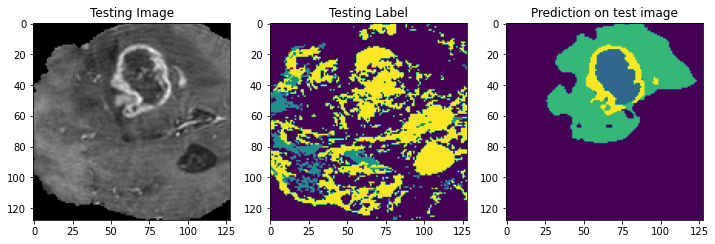

In [99]:
#############################################
#Predict on a few test images, one at a time
#Try images: 
img_num = 82
pred_time = time.time()
test_img = np.load(r"D:\Amjid data\segmentation\train_val_dataset\train\images\image_0.npy")

test_mask = np.load(r"D:\Amjid data\segmentation\train_val_dataset\train\images\image_0.npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)

test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
pred_end = time.time() - pred_time

# # print(test_prediction_argmax.shape)
# # print(test_mask_argmax.shape)
# # print(np.unique(test_prediction_argmax))


# #Plot individual slices from test predictions for verification
# from matplotlib import pyplot as plt
# import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()


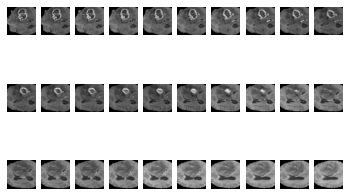

In [115]:
import matplotlib.pyplot as plt

# Generate an array of 128x128 pixel images
# images = [image_data_1, image_data_2, ..., image_data_n]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=10)

# Plot the images in the subplots
for i, ax in enumerate(axes.ravel()):
    ax.imshow(test_img[:,:,i+50,1],'gray')
    ax.axis('off')

# Save the figure
plt.savefig('testing_images.png', dpi=500)

In [104]:
print("prediction time:",pred_end)

prediction time: 1.041682481765747


In [116]:
import gc
gc.collect()

152101